In [1]:
# Import libraies
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline

In [2]:
# 1. Load "ModifiedEdibleMushroom.csv" data from the link below (note: this data set has been preliminarily prepared.).
df = pd.read_csv('https://github.com/pvateekul/2110446_DSDE_2023s2/raw/main/code/Week03_ML/mushroom2020_dataset.csv')
df.shape

(5824, 24)

In [3]:
# 2. Drop rows where the target (label) variable is missing.
df.dropna(subset=['label'],inplace=True)
df.shape

(5764, 24)

In [4]:
# 3. Drop the following variables:
# 'id','gill-attachment', 'gill-spacing', 'gill-size','gill-color-rate', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring-rate','stalk-color-below-ring-rate','veil-color-rate','veil-type'
columns_to_drop = ['id', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color-rate', 'stalk-root', 'stalk-surface-above-ring',
                   'stalk-surface-below-ring', 'stalk-color-above-ring-rate', 'stalk-color-below-ring-rate', 'veil-color-rate', 'veil-type']
df.drop(columns=columns_to_drop, inplace=True)
# df

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

num_cols = ['cap-color-rate']
cat_cols = ['cap-shape', 'cap-surface', 'bruises', 'odor', 'stalk-shape',
            'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [6]:
from sklearn.compose import ColumnTransformer

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)],
    n_jobs=-1)

In [7]:
from sklearn.ensemble import RandomForestClassifier

params = {
    "criterion": "gini",
    "max_depth": 1,
    "min_samples_leaf": 2,
    "random_state": 2020,
    "n_estimators": 100
}
rfc = RandomForestClassifier(**params)
model_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', rfc)
])

In [8]:
from sklearn import set_config

set_config(display='diagram')
display(model_pipeline)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['cap-color-rate']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['cap-shape', 'cap-surface',
                                                   'bruises', 'odor',
                                                   'stalk-shape', 'ring-number',
                                                   'ring-type',
                                                   'spore-print-color',
                                                   'population',
                                                   'habitat'])])),
                ('model',
                 RandomForestClassifier(max_depth=1, min_samples_leaf=2,
                                        random_state=2020))])

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
X = df[num_cols+cat_cols]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2020)

In [10]:
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Edible', 'Posionous'], digits=4))

              precision    recall  f1-score   support

      Edible     0.9596    0.8456    0.8990       421
   Posionous     0.9169    0.9795    0.9472       732

    accuracy                         0.9306      1153
   macro avg     0.9382    0.9126    0.9231      1153
weighted avg     0.9325    0.9306    0.9296      1153



In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

param_grid= {
            'model__criterion':['gini','entropy'], 
            'model__max_depth': [2,3,6], 
            'model__min_samples_leaf':[2,5,10], 
            'model__n_estimators':[100,200], 
            'model__random_state': [2020]}
gs_pipeline = GridSearchCV(model_pipeline, param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
gs_pipeline.fit(X_train, y_train)
print("Best parameter set: "+str(gs_pipeline.best_params_))

Best parameter set: {'model__criterion': 'gini', 'model__max_depth': 6, 'model__min_samples_leaf': 2, 'model__n_estimators': 100, 'model__random_state': 2020}


In [12]:
from sklearn.metrics import accuracy_score

y_predict = model_pipeline.predict(X_test)
accuracy = accuracy_score(y_test,y_predict)


In [14]:
import mlflow
from mlflow.models import infer_signature

# mlflow server --host 127.0.0.1 --port 8080
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("assignment5")
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(param_grid)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "mushroom")

    # Infer the model signature
    signature = infer_signature(X_train, gs_pipeline.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_pipeline,
        artifact_path="mushroom",
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-quickstart",
    )

2024/04/21 22:35:42 INFO mlflow.tracking.fluent: Experiment with name 'assignment5' does not exist. Creating a new experiment.


Successfully registered model 'tracking-quickstart'.
2024/04/21 22:35:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-quickstart, version 1
Created version '1' of model 'tracking-quickstart'.


In [ ]:
# model_uri = "mlflow-artifacts:/500594208033447495/14cefef41be14617bfca3438e755ed4c/artifacts/mushroom"
# mlflow.register_model(model_uri=model_uri, name="mushroom")

In [15]:
model_name = "tracking-quickstart"
model_version = 1

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}")

# Predict on a Pandas DataFrame.
predicted = loaded_model.predict(pd.DataFrame(X_test))

2024/04/21 22:36:31 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


In [ ]:
from sklearn.metrics import  classification_report
print(classification_report(y_test, predicted, target_names=['Edible', 'Posionous'], digits=4))

              precision    recall  f1-score   support

      Edible     0.9596    0.8456    0.8990       421
   Posionous     0.9169    0.9795    0.9472       732

    accuracy                         0.9306      1153
   macro avg     0.9382    0.9126    0.9231      1153
weighted avg     0.9325    0.9306    0.9296      1153



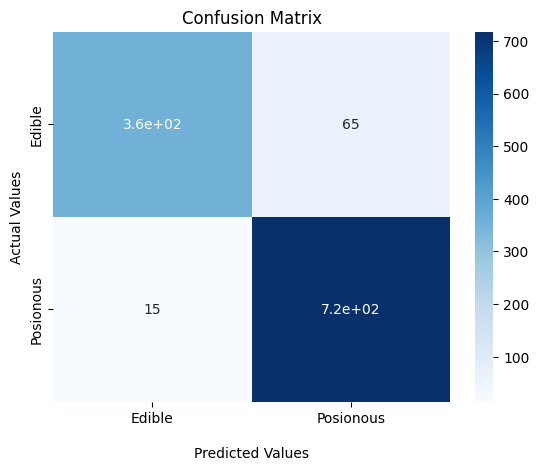

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_matrix(y_test, y_pred):
    conf = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(conf, annot=True, cmap='Blues')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values');
    ax.xaxis.set_ticklabels(['Edible', 'Posionous'])
    ax.yaxis.set_ticklabels(['Edible', 'Posionous'])
    plt.show()

conf_matrix(y_test, y_pred)

In [ ]:
# from pyngrok import ngrok
# import os
# from dotenv import load_dotenv
# load_dotenv()
# ngrok.kill()

# # #Get your authtoken from https://dashboard.ngrok.com/auth
# NGROK_AUTH_TOKEN = os.getenv("NGROK_AUTH_TOKEN")
# ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# # Open an HTTPs tunnel on port 5000 for http://localhost:5000
# ngrok_tunnel = ngrok.connect(addr='8080', proto='http', bind_tls=True)
# # ngrok_tunnel = ngrok.connect(addr='8080', proto='http')
# print("MLflow Tracking UI: ", ngrok_tunnel.public_url)